In [ ]:
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon

In [ ]:
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

100%|██████████████████████████████████████████████████████████████████████████████| 314M/314M [00:24<00:00, 12.6MiB/s]
INFO:datasetsforecast.utils:Successfully downloaded datasets.zip, 314116557, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed longhorizon\datasets\datasets.zip


,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


In [ ]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer

According to the repository, the following parameters were used for TSMixer on the ETTm2 dataset:

- learning rate = 0.001
- n_blocks = 2
- dropout = 0.9
- ff_dim = 64 (used for feature mixing only)

The horizon was 96

The input length was 512

In [ ]:
from neuralforecast.losses.pytorch import MSE

horizon = 96 # 24hrs = 4 * 15 min.
models = [TSMixer(h=horizon,                    # Forecasting horizon
                  n_series=7,                   # Number of series
                  dropout_rate=0.9,             # Rate of dropout
                  n_blocks=2,                   # Number of mixing blocks
                  ff_dim=64,                    # Dimension of the feedforward layer for feature mixing
                  loss=MSE(),
                  input_size=512,               # Input size
                  max_steps=1000,               # Number of training iterations
                  val_check_steps=100,          # Compute validation loss every 100 steps
                  early_stop_patience_steps=3,  # Stop training if validation loss does not improve
                  batch_size=96), 
         ]

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf = NeuralForecast(
    models=models,
    freq='15min')

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None)

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

<matplotlib.legend.Legend>

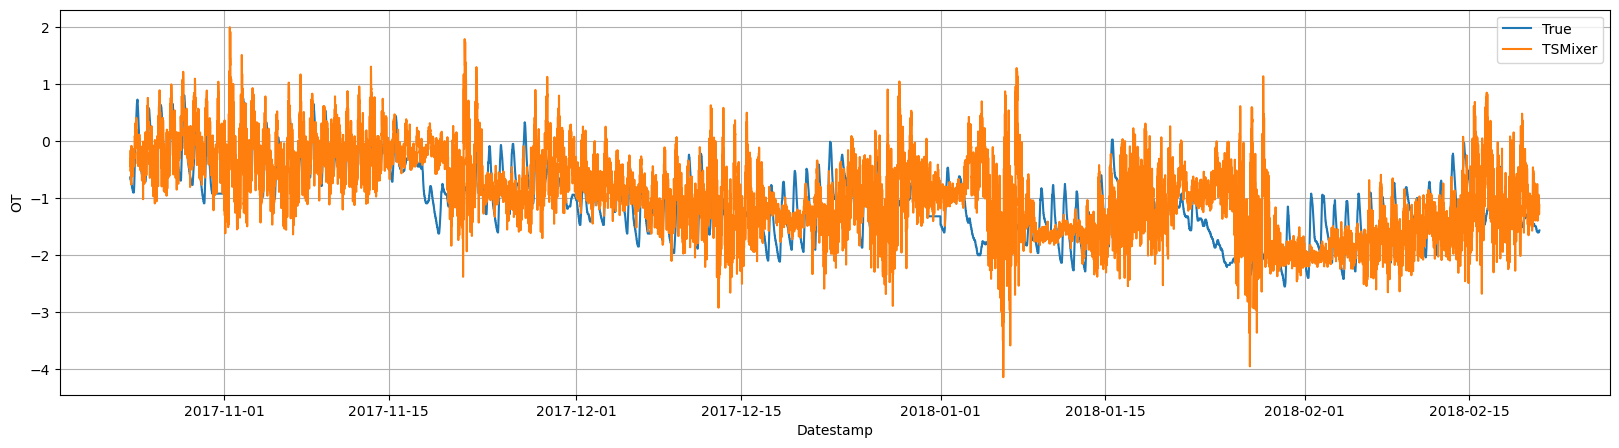

In [ ]:
import matplotlib.pyplot as plt

Y_plot = Y_hat_df[Y_hat_df['unique_id']=='OT'] # OT dataset
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['TSMixer'], label='TSMixer')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()

In [ ]:
from neuralforecast.losses.numpy import mae

mae_tsmixer = mae(Y_hat_df['y'], Y_hat_df['TSMixer'])

print(f'TSMixer: {mae_tsmixer:.3f}')

TSMixer: 0.543


The reported MAE in the paper for Ettm2 and horizon of 96 is 0.252